In [1]:
import numpy as np, pandas as pd, matplotlib.pyplot as plt
import shutil, time, re, mne, matplotlib, torch, os, sys
from torch import nn
from torch.utils.data import Dataset, DataLoader
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), os.pardir)))
from modd.datasets import *
from modd.transformer import *

### Obtención de gráfica para un individuo y consenso de anotaciones

e:\Drive-Seba\UChile\10mo semestre\Teoria de la Información\Mismodelling-on-Time-Series\modd\datasets.py:18: RuntimeWarning: Invalid date encountered (2000-00-00 00:00:00).
  raw = mne.io.read_raw_edf(raw_file, preload=True, verbose=False)


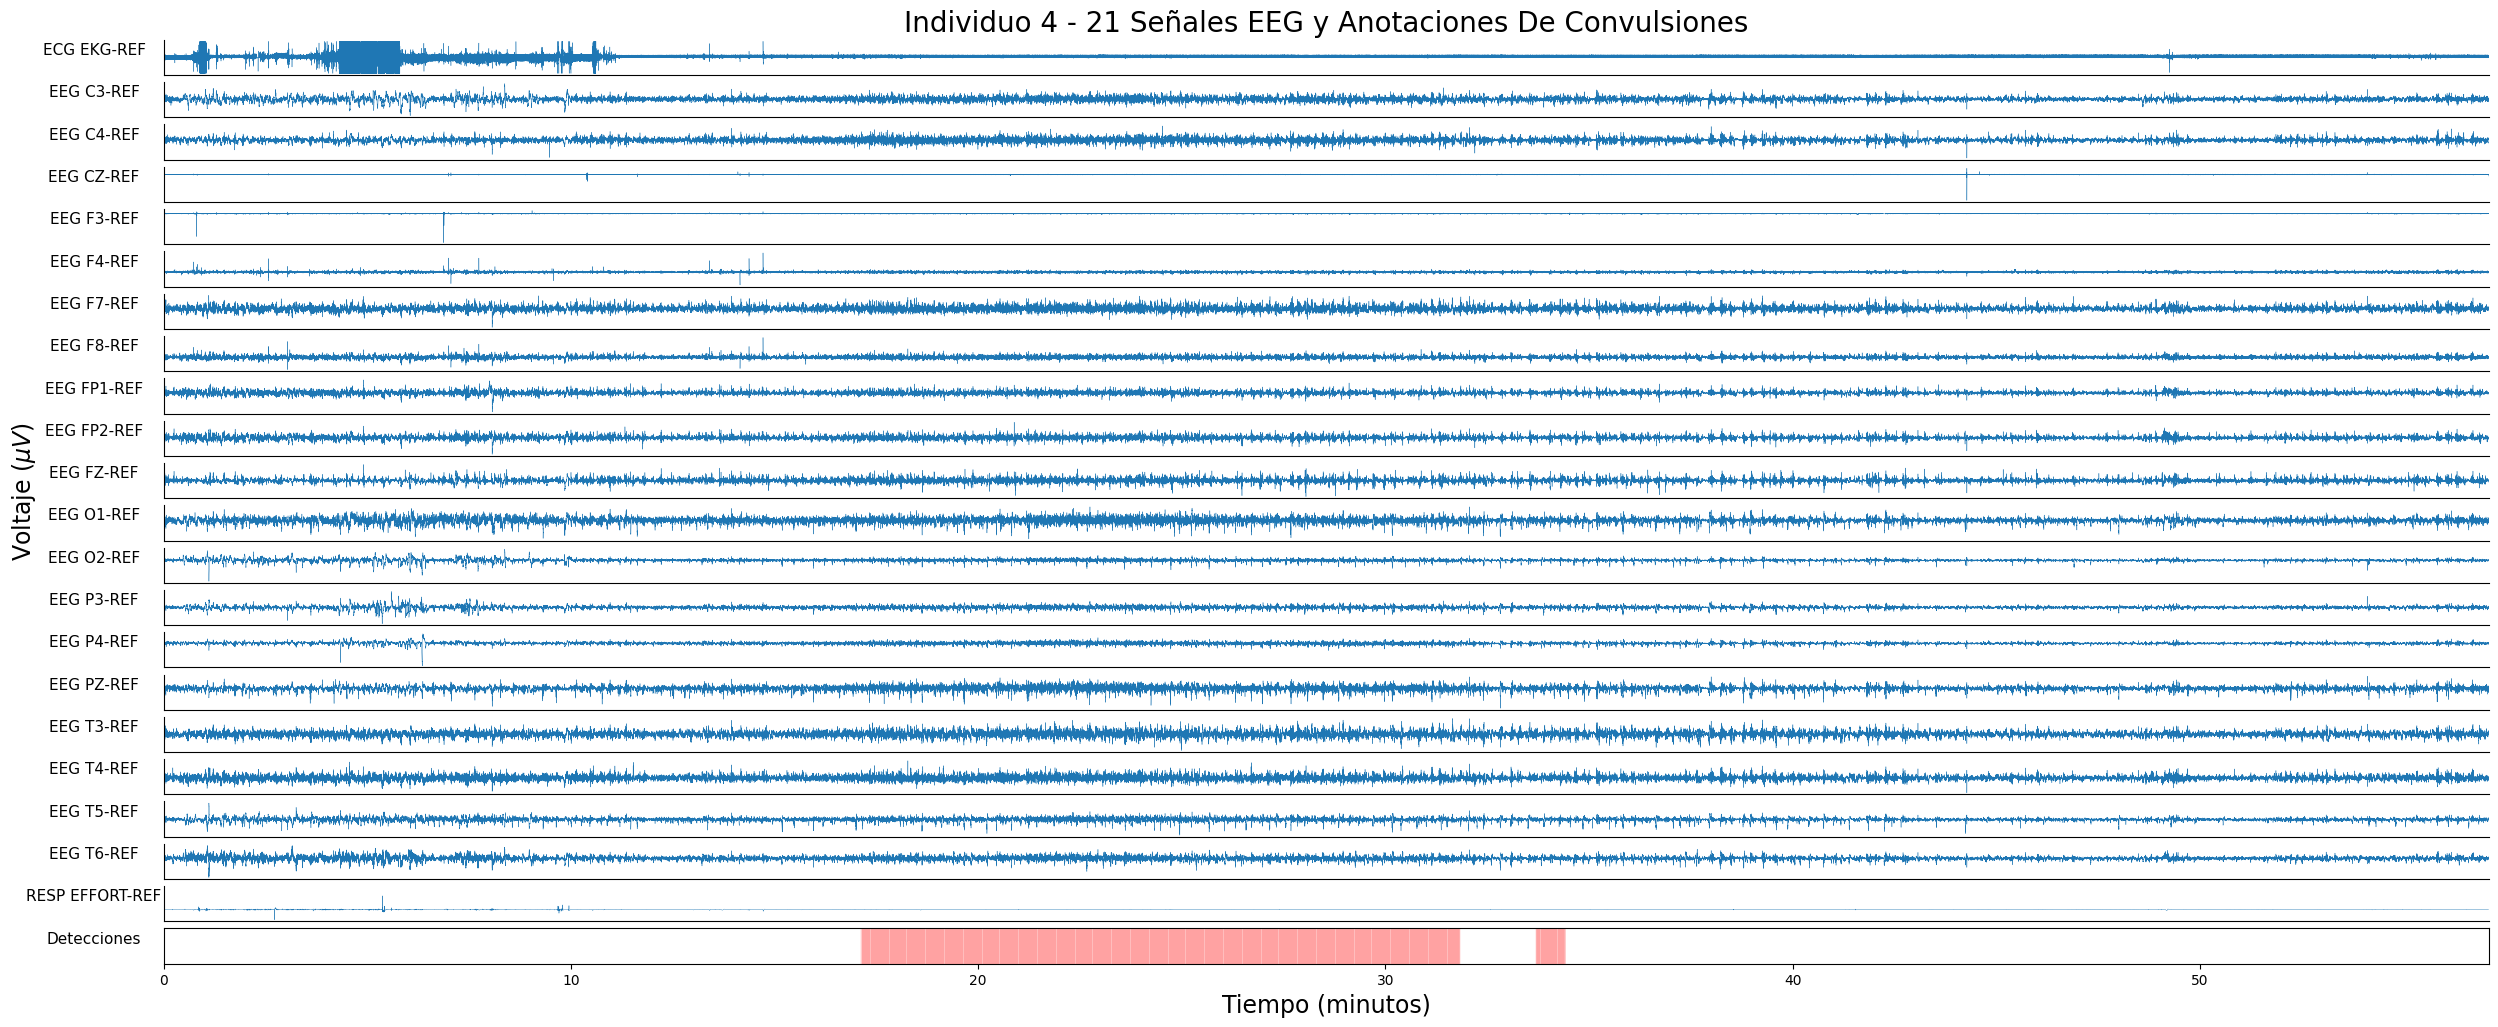

e:\Drive-Seba\UChile\10mo semestre\Teoria de la Información\Mismodelling-on-Time-Series\modd\datasets.py:18: RuntimeWarning: Invalid date encountered (2000-00-00 00:00:00).
  raw = mne.io.read_raw_edf(raw_file, preload=True, verbose=False)


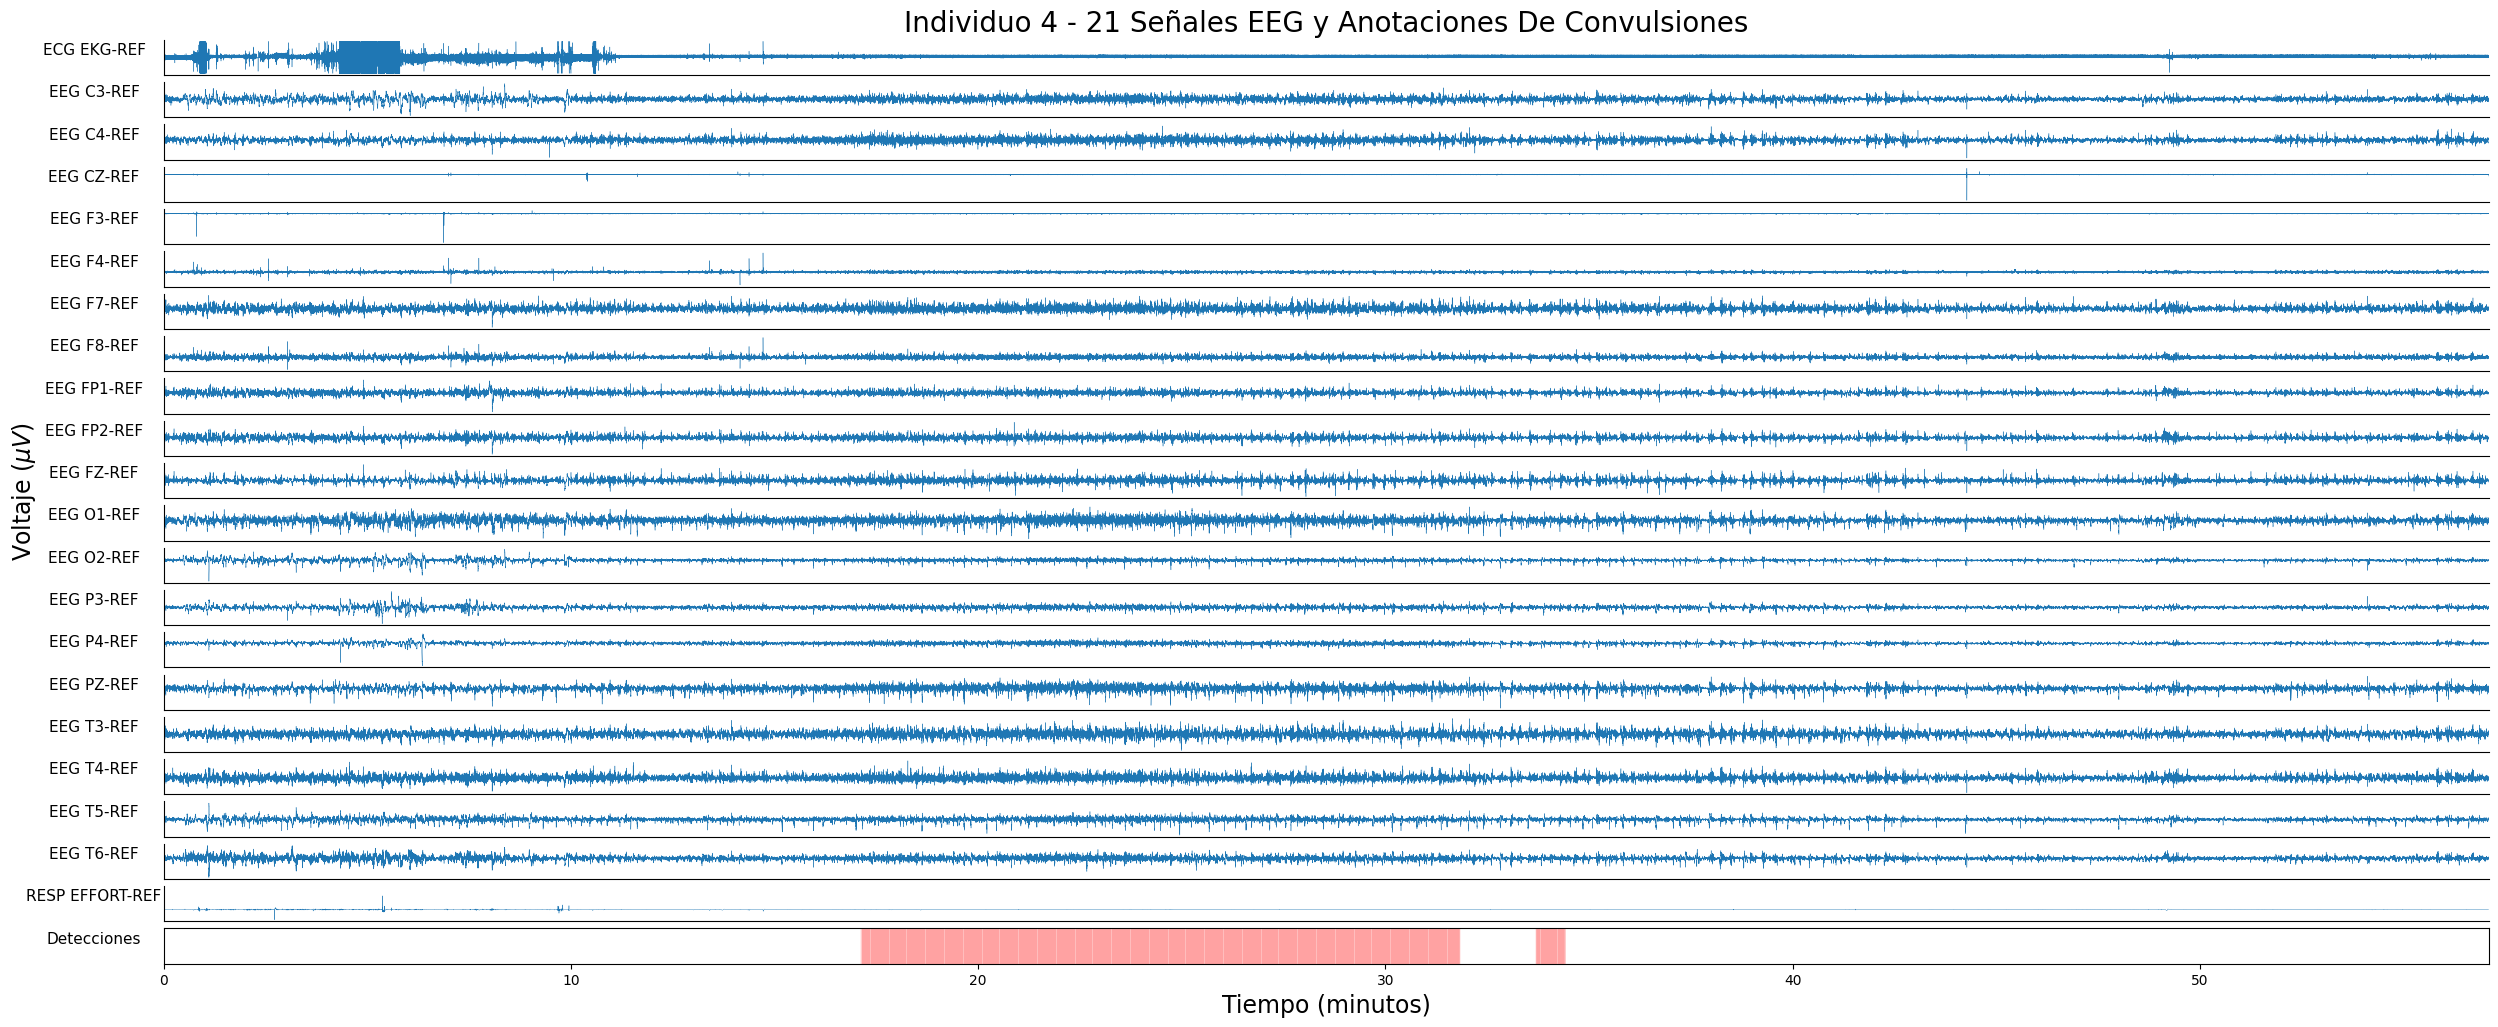

In [2]:
import os, sys
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), os.pardir)))
from modd.datasets import *
# Test dataset
dataset = EegDataset()
dataset_nominal = EegDatasetNominal()
dataset.plot(3)
dataset_nominal.plot(3)

e:\Drive-Seba\UChile\10mo semestre\Teoria de la Información\Mismodelling-on-Time-Series\modd\datasets.py:18: RuntimeWarning: Invalid date encountered (2000-00-00 00:00:00).
  raw = mne.io.read_raw_edf(raw_file, preload=True, verbose=False)


(3761, 21, 256)


e:\Drive-Seba\UChile\10mo semestre\Teoria de la Información\Mismodelling-on-Time-Series\modd\datasets.py:18: RuntimeWarning: Invalid date encountered (2000-00-00 00:00:00).
  raw = mne.io.read_raw_edf(raw_file, preload=True, verbose=False)


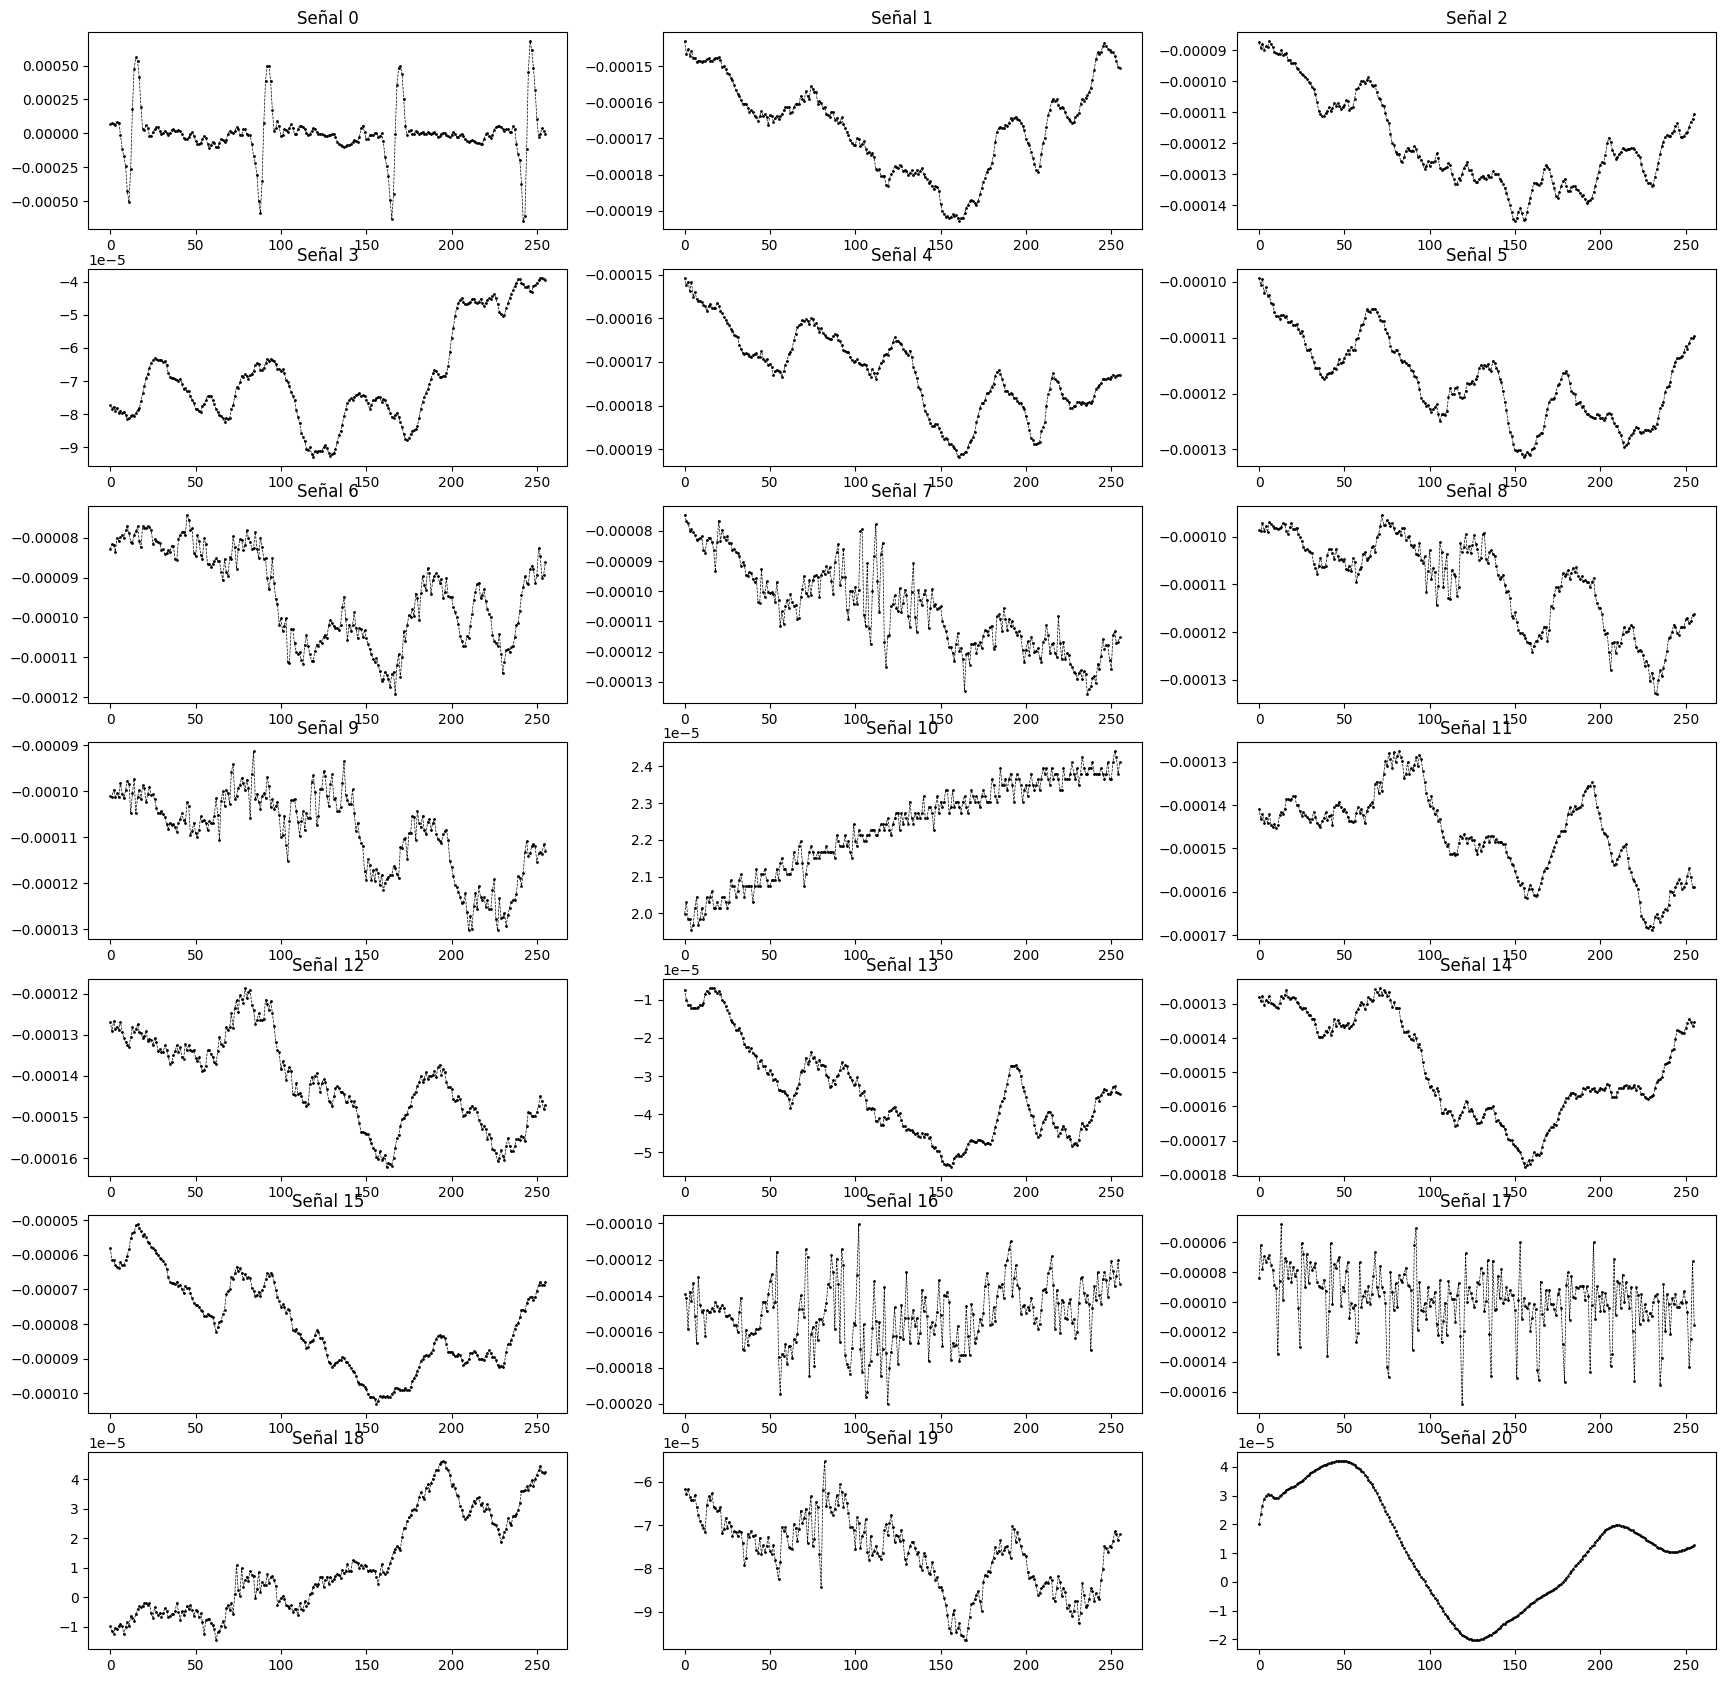

In [3]:
# Printear las dimensiones de los datos
# dataset_nominal[0] ((segmentos:N_variable, canales:21, muestras:256), anotaciones)
# dataset_nominal[0][0] señales: (segmentos, canales, muestras)
print(dataset_nominal[0][0].shape)
segmento = dataset_nominal[0][0][0]
fig, axs = plt.subplots(7, 3, figsize=(21, 21))
for i in range(7):
    for j in range(3):
        # graficar los puntos
        axs[i, j].plot(segmento[i*3+j], color='black',marker='o', linestyle='dashed',linewidth=0.5, markersize=1)
        axs[i, j].set_title("Señal "+str(i*3+j))
plt.show()

In [4]:

import torch
import torch.nn as nn
import torch.optim as optim
import pytorch_lightning as pl
import matplotlib.pyplot as plt
import math

class TransformerEncoder(nn.Module):
    def __init__(self, d_model, nhead, num_layers, dim_feedforward, dropout=0.1, max_length=256, channels=21):
        super(TransformerEncoder, self).__init__()
        self.embedding = nn.Linear(channels, d_model)
        encoder_layer = nn.TransformerEncoderLayer(d_model, nhead, dim_feedforward, dropout, batch_first=True, activation='gelu', norm_first=True)
        self.transformer_encoder = nn.TransformerEncoder(encoder_layer, num_layers)
        self.positional_encoding = self.generate_positional_encoding(d_model, max_length)
        self.decoder = nn.Linear(d_model, channels)
    
    def forward(self, x):
        # x : (batch_size, seq_len, d_model), pos_enc: (1, seq_len, d_model), mask: (batch_size, seq_len, seq_len)
        b, s, c = x.shape
        x = self.embedding(x)
        x = x + self.positional_encoding[:x.size(1), :].unsqueeze(0).to(x.device)
        causal_mask = self.generate_causal_mask(b, s).to(x.device)
        x = self.transformer_encoder(x, is_causal = True, mask = causal_mask)
        x = self.decoder(x)
        return x

    def generate_causal_mask(self, batch, seq_len):
        return torch.tril(torch.ones(seq_len, seq_len), diagonal=0).unsqueeze(0).repeat(batch, 1, 1)

    def generate_positional_encoding(self, d_model, max_length): # Attention is all you need
        pe = torch.zeros(max_length, d_model)
        position = torch.arange(0, max_length).unsqueeze(1).float()
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term) # ej: 0::2 -> 0, 2, 4, 6, 8, ...
        pe[:, 1::2] = torch.cos(position * div_term) # ej: 1::2 -> 1, 3, 5, 7, 9, ...
        return pe

class TransformerModel(pl.LightningModule):
    def __init__(self, d_model, nhead, num_layers, dim_feedforward, dropout=0.1, learning_rate=1e-3, loss_fn=nn.MSELoss()):
        super(TransformerModel, self).__init__()
        self.model = TransformerEncoder(d_model, nhead, num_layers, dim_feedforward)
        self.learning_rate = learning_rate  # Agrega el hiperparámetro learning_rate
        self.loss_function = loss_fn

    def forward(self, x):
        return self.model(x)

    def training_step(self, batch, batch_idx):
        x, y = batch
        output = self(x)
        loss = self.loss_function(output, y)
        self.log('train/loss', loss)
        return loss
    
    def validation_step(self, batch, batch_idx):
        x, y = batch
        output = self(x)
        loss = self.loss_function(output, y)
        self.log('val/loss', loss)
        return loss

    def configure_optimizers(self):
        return optim.Adam(self.parameters(), lr=self.learning_rate)
    
# Crear una instancia del modelo con hiperparámetros personalizables (d_model % nhead = 0)
model = TransformerModel(d_model=40, nhead=4, num_layers=4, dim_feedforward=1024, dropout=0.1, learning_rate=1e-5)

# Plotear máscara
x = torch.randn(3, 256, 21) # Comparar con (K*256, 21)
y = model(x)
print(y.shape)

e:\Drive-Seba\UChile\10mo semestre\Teoria de la Información\Mismodelling-on-Time-Series\.env\lib\site-packages\torch\nn\modules\transformer.py:282: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.norm_first was True
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


torch.Size([3, 256, 21])


In [5]:
dataset_nominal = EegDatasetNominal()
dataset_nominal.columns[14]

'35'

In [6]:
dataset = EegDataset()
dataset_nominal = EegDatasetNominal()
# Separar en train 70, val 10, test 20
train_len = int(len(dataset_nominal)*0.8)
val_len = int(len(dataset_nominal)*0.1)
test_len = len(dataset_nominal) - train_len - val_len
print(" Train: ", round(train_len/len(dataset_nominal) * 100, 2), "% -> ", train_len)
print(" Val: ", round(val_len/len(dataset_nominal) * 100, 2), "% -> ", val_len)
print(" Test: ", round(test_len/len(dataset_nominal) * 100, 2), "% -> ", test_len)
train_dataset, val_dataset, test_dataset = torch.utils.data.random_split(dataset_nominal, [train_len, val_len, test_len])

 Train:  78.79 % ->  26
 Val:  9.09 % ->  3
 Test:  12.12 % ->  4


In [7]:
# Clear output console
from IPython.display import clear_output
# X son las secuencias y Y son las secuencias del instante siguiente
def create_data(dataset):
    X, Y = [], []
    for i in range(len(dataset)):
        segments = dataset[i][0]
        clear_output()
        for j in range(len(segments)-1):
            X.append(segments[j])
            Y.append(segments[j+1])
    return torch.tensor(X), torch.tensor(Y)
# Crear los datasets
# X_train, Y_train = create_data(train_dataset)
# X_val, Y_val = create_data(val_dataset)
# X_test, Y_test = create_data(test_dataset) 

In [9]:
# Guardar datos en un archivo
path = '../transformer_data/'
# torch.save(X_train, path+'X_train.pt')
# torch.save(Y_train, path+'Y_train.pt')
# torch.save(X_val, path+'X_val.pt')
# torch.save(Y_val, path+'Y_val.pt')
# torch.save(X_test, path+'X_test.pt')
# torch.save(Y_test, path+'Y_test.pt')

In [10]:
# Crear un dataset con los datos de train y test
class EegDatasetNominalPairs(Dataset):
    def __init__(self, X, Y):
        self.X = X
        self.Y = Y

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.Y[idx]

# Crear los datasets de train y test
X_train = torch.load(path+'X_train.pt')
Y_train = torch.load(path+'Y_train.pt')
X_val = torch.load(path+'X_val.pt')
Y_val = torch.load(path+'Y_val.pt')
X_test = torch.load(path+'X_test.pt')
Y_test = torch.load(path+'Y_test.pt')
# Crear los datasets
train_dataset = EegDatasetNominalPairs(X_train, Y_train)
val_dataset = EegDatasetNominalPairs(X_val, Y_val)
test_dataset = EegDatasetNominalPairs(X_test, Y_test)

In [11]:
print(len(X_train), len(X_test), len(X_val))

126008 16453 12811


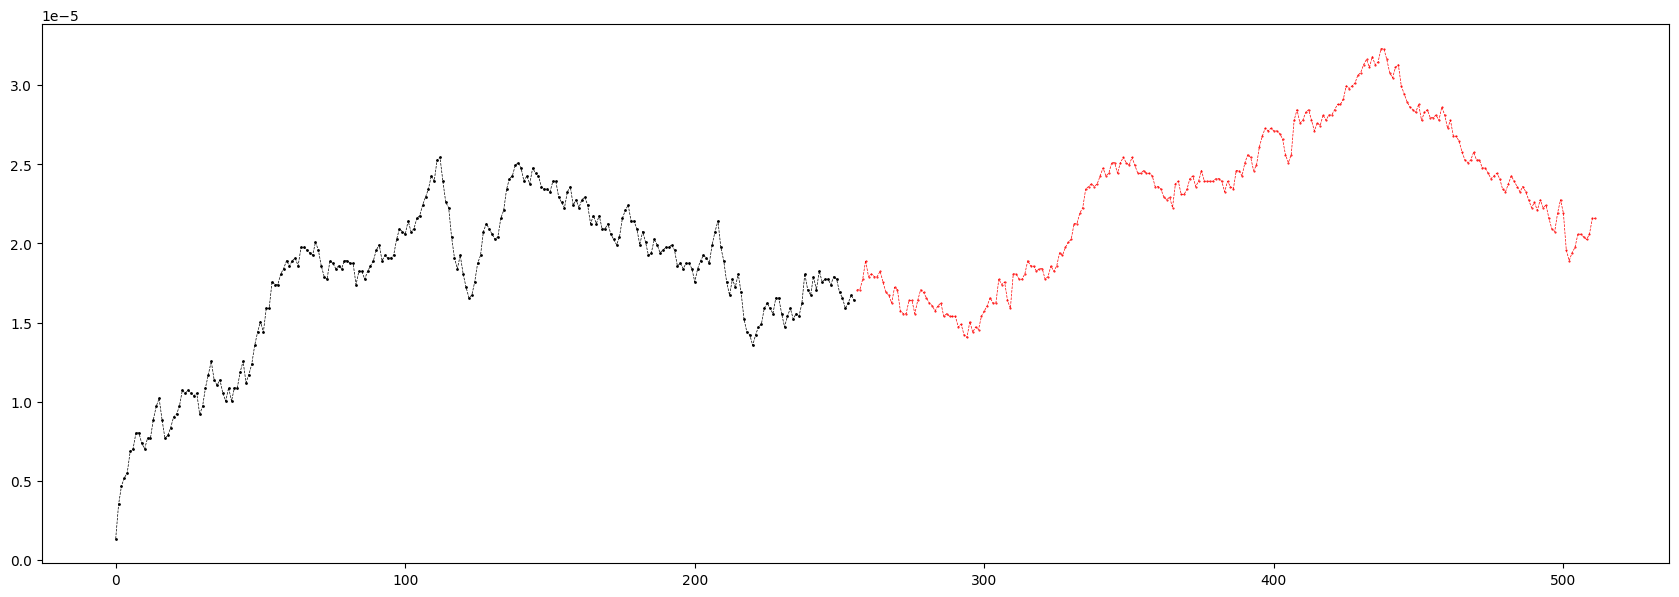

In [12]:
# Verificar que los datos sean correctos
fig, ax = plt.subplots(1, 1, figsize=(21, 7))
ax.plot(train_dataset[0][0][1], color='black',marker='o', linestyle='dashed',linewidth=0.5, markersize=1)
ax.plot(np.arange(0, 256)+256, train_dataset[0][1][1], color='red',marker='.', linestyle='dashed',linewidth=0.5, markersize=1)
plt.show()